<a href="https://colab.research.google.com/github/ayush9h/PyTorch-DeepLearning/blob/main/Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [22]:
prob = 0.25

dropout = nn.Dropout(p = prob)
x = torch.ones(10)

In [23]:
Y = dropout(x)
print(x)
print(Y)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([1.3333, 1.3333, 1.3333, 1.3333, 0.0000, 1.3333, 0.0000, 1.3333, 1.3333,
        1.3333])


In [24]:
print(torch.mean(Y))

tensor(1.0667)


In [25]:
dropout.eval()
y = dropout(x)
print(y)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


In [26]:
print(torch.mean(y))

tensor(1.)


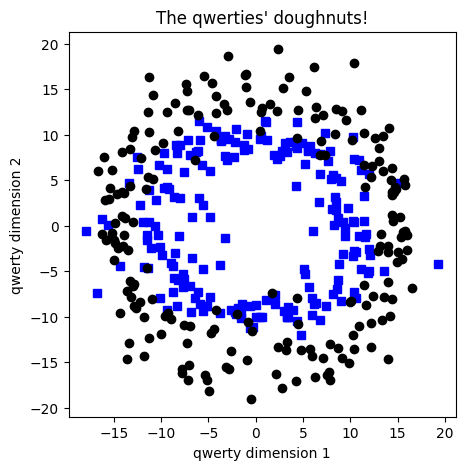

In [27]:
import numpy as np
import matplotlib.pyplot as plt

nPerClust = 200

th = np.linspace(0,4*np.pi,nPerClust)
r1 = 10
r2 = 15

# generate data
a = [ r1*np.cos(th) + np.random.randn(nPerClust)*3 ,
      r1*np.sin(th) + np.random.randn(nPerClust) ]
b = [ r2*np.cos(th) + np.random.randn(nPerClust) ,
      r2*np.sin(th) + np.random.randn(nPerClust)*3 ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title("The qwerties' doughnuts!")
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()


In [28]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)

train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0]) # how big should these batches be??


In [29]:
class theModelClass(nn.Module):
  def __init__(self,dropoutRate):
    super().__init__()

    self.input  = nn.Linear(  2,128)
    self.hidden = nn.Linear(128,128)
    self.output = nn.Linear(128, 1)

    self.dr = dropoutRate

  def forward(self,x):

    x = F.relu( self.input(x) )

    x = F.dropout(x,p=self.dr,training=self.training)
    x = F.relu( self.hidden(x) )

    x = F.dropout(x,p=self.dr,training=self.training)
    x = self.output(x)

    return x

In [30]:
def createANewModel(dropoutrate):

  ANNQC = theModelClass(dropoutrate)

  lossfun = nn.BCEWithLogitsLoss()

  optimizer = torch.optim.SGD(ANNQC.parameters(),lr=.002)

  return ANNQC,lossfun,optimizer

In [31]:
numepochs = 1000

In [32]:
def trainTheModel(ANNQC,lossfun,optimizer):

  trainAcc = []
  testAcc  = []


  # loop over epochs
  for epochi in range(numepochs):

    # switch training mode on (is this the right place for this code??)
    ANNQC.train()

    # loop over training data batches
    batchAcc = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNQC(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean(((yHat>0)==y).float()).item() )
    trainAcc.append( np.mean(batchAcc) )

    ANNQC.eval() # switch training off
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = ANNQC(X)
    testAcc.append( 100*torch.mean(((yHat>0)==y).float()).item() )

  return trainAcc,testAcc

In [35]:
dropoutrate = .25
ANNQC,lossfun,optimizer = createANewModel(dropoutrate)

trainAcc,testAcc = trainTheModel(ANNQC,lossfun,optimizer)

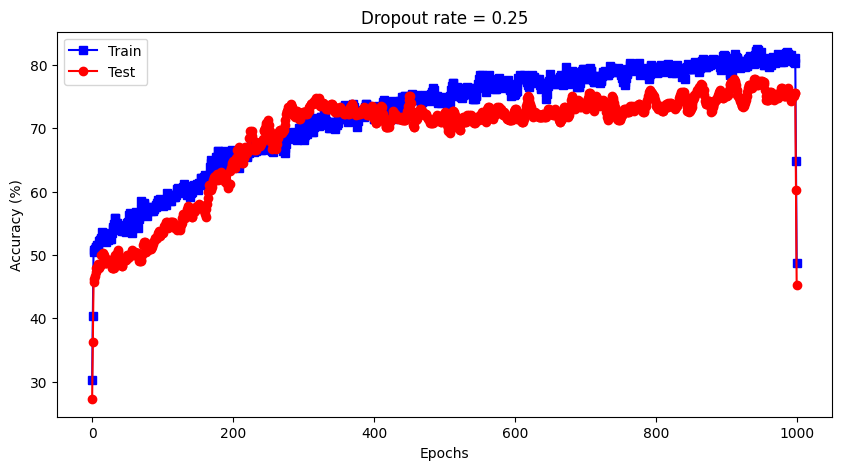

In [36]:
def smooth(x,k=5):
  return np.convolve(x,np.ones(k)/k,mode='same')


fig = plt.figure(figsize=(10,5))

plt.plot(smooth(trainAcc),'bs-')
plt.plot(smooth(testAcc),'ro-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.title('Dropout rate = %g'%dropoutrate)

plt.show()